# The Agent Loop: Building Production Agents with LangChain 1.0

In this notebook, we'll explore the foundational concepts of AI agents and learn how to build production-grade agents using LangChain's new `create_agent` abstraction with middleware support.

**Learning Objectives:**
- Understand what an "agent" is and how the agent loop works
- Learn the core constructs of LangChain (Runnables, LCEL)
- Master the `create_agent` function and middleware system
- Build an agentic RAG application using Qdrant

## Table of Contents:

- **Breakout Room #1:** Introduction to LangChain, LangSmith, and `create_agent`
  - Task 1: Dependencies
  - Task 2: Environment Variables
  - Task 3: LangChain Core Concepts (Runnables & LCEL)
  - Task 4: Understanding the Agent Loop
  - Task 5: Building Your First Agent with `create_agent()`
  - Question #1 & Question #2
  - Activity #1: Create a Custom Tool

- **Breakout Room #2:** Middleware - Agentic RAG with Qdrant
  - Task 6: Loading & Chunking Documents
  - Task 7: Setting up Qdrant Vector Database
  - Task 8: Creating a RAG Tool
  - Task 9: Introduction to Middleware
  - Task 10: Building Agentic RAG with Middleware
  - Question #3 & Question #4
  - Activity #2: Enhance the Agent

---
# 🤝 Breakout Room #1
## Introduction to LangChain, LangSmith, and `create_agent`

## Task 1: Dependencies

First, let's ensure we have all the required packages installed. We'll be using:

- **LangChain 1.0+**: The core framework with the new `create_agent` API
- **LangChain-OpenAI**: OpenAI model integrations
- **LangSmith**: Observability and tracing
- **Qdrant**: Vector database for RAG
- **tiktoken**: Token counting for text splitting

In [1]:
# Run this cell to install dependencies (if not using uv sync)
# !pip install langchain>=1.0.0 langchain-openai langsmith langgraph qdrant-client langchain-qdrant tiktoken nest-asyncio

In [2]:
# Core imports we'll use throughout the notebook
import os
import getpass
from uuid import uuid4

import nest_asyncio
nest_asyncio.apply()  # Required for async operations in Jupyter

## Task 2: Environment Variables

We need to set up our API keys for:
1. **OpenAI** - For the GPT-5 model
2. **LangSmith** - For tracing and observability (optional but recommended)

In [3]:
# Set OpenAI API Key
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key: ")

In [4]:
# Optional: Set up LangSmith for tracing
# This provides powerful debugging and observability for your agents

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE9 - The Agent Loop - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key (press Enter to skip): ") or ""

if not os.environ["LANGCHAIN_API_KEY"]:
    os.environ["LANGCHAIN_TRACING_V2"] = "false"
    print("LangSmith tracing disabled")
else:
    print(f"LangSmith tracing enabled. Project: {os.environ['LANGCHAIN_PROJECT']}")

LangSmith tracing enabled. Project: AIE9 - The Agent Loop - 15cb98ea


## Task 3: LangChain Core Concepts

Before diving into agents, let's understand the fundamental building blocks of LangChain.

### What is a Runnable?

A **Runnable** is the core abstraction in LangChain - think of it as a standardized component that:
- Takes an input
- Performs some operation
- Returns an output

Every component in LangChain (models, prompts, retrievers, parsers) is a Runnable, which means they all share the same interface:

```python
result = runnable.invoke(input)           # Single input
results = runnable.batch([input1, input2]) # Multiple inputs
for chunk in runnable.stream(input):       # Streaming
    print(chunk)
```

### What is LCEL (LangChain Expression Language)?

**LCEL** allows you to chain Runnables together using the `|` (pipe) operator:

```python
chain = prompt | model | output_parser
result = chain.invoke({"query": "Hello!"})
```

This is similar to Unix pipes - the output of one component becomes the input to the next.

In [5]:
# Let's see LCEL in action with a simple example
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Create our components (each is a Runnable)
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant that speaks like a pirate."),
    ("human", "{question}")
])

model = ChatOpenAI(model="gpt-5", temperature=0.7)

output_parser = StrOutputParser()

# Chain them together with LCEL
pirate_chain = prompt | model | output_parser

In [6]:
# Invoke the chain
response = pirate_chain.invoke({"question": "What is the capital of France?"})
print(response)

Arrr, that’d be Paris, matey!


## Task 4: Understanding the Agent Loop

### What is an Agent?

An **agent** is a system that uses an LLM to decide what actions to take. Unlike a simple chain that follows a fixed sequence, an agent can:

1. **Reason** about what to do next
2. **Take actions** by calling tools
3. **Observe** the results
4. **Iterate** until the task is complete

### The Agent Loop

The core of every agent is the **agent loop**:

```
                          AGENT LOOP                         
                                                             
      +----------+     +----------+     +----------+         
      |  Model   | --> |   Tool   | --> |  Model   | --> ... 
      |   Call   |     |   Call   |     |   Call   |         
      +----------+     +----------+     +----------+         
           |                                  |              
           v                                  v              
      "Use search"                   "Here's the answer"     
```

1. **Model Call**: The LLM receives the current state and decides whether to:
   - Call a tool (continue the loop)
   - Return a final answer (exit the loop)

2. **Tool Call**: If the model decides to use a tool, the tool is executed and its output is added to the conversation

3. **Repeat**: The loop continues until the model decides it has enough information to answer

### Why `create_agent`?

LangChain 1.0 introduced `create_agent` as the new standard way to build agents. It provides:

- **Simplified API**: One function to create production-ready agents
- **Middleware Support**: Hook into any point in the agent loop
- **Built on LangGraph**: Uses the battle-tested LangGraph runtime under the hood

## Task 5: Building Your First Agent with `create_agent()`

Let's build a simple agent that can perform calculations and tell the time.

### Step 1: Define Tools

Tools are functions that the agent can call. We use the `@tool` decorator to create them.

In [7]:
from langchain_core.tools import tool

@tool
def calculate(expression: str) -> str:
    """Evaluate a mathematical expression. Use this for any math calculations.
    
    Args:
        expression: A mathematical expression to evaluate (e.g., '2 + 2', '10 * 5')
    """
    try:
        # Using eval with restricted globals for safety
        result = eval(expression, {"__builtins__": {}}, {})
        return f"The result of {expression} is {result}"
    except Exception as e:
        return f"Error evaluating expression: {e}"

@tool
def get_current_time() -> str:
    """Get the current date and time. Use this when the user asks about the current time or date."""
    from datetime import datetime
    return f"The current date and time is: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"

# Create our tool belt
tools = [calculate, get_current_time]

print("Tools created:")
for t in tools:
    print(f"  - {t.name}: {t.description[:60]}...")

Tools created:
  - calculate: Evaluate a mathematical expression. Use this for any math ca...
  - get_current_time: Get the current date and time. Use this when the user asks a...


### Step 2: Create the Agent

Now we use `create_agent` to build our agent. The function takes:
- `model`: The LLM to use (can be a string like `"gpt-5"` or a model instance)
- `tools`: List of tools the agent can use
- `prompt`: Optional system prompt to customize behavior

In [8]:
from langchain.agents import create_agent

# Create our first agent
simple_agent = create_agent(
    model="gpt-5",
    tools=tools,
    system_prompt="You are a helpful assistant that can perform calculations and tell the time. Always explain your reasoning."
)

print("Agent created successfully!")
print(f"Type: {type(simple_agent)}")

Agent created successfully!
Type: <class 'langgraph.graph.state.CompiledStateGraph'>


### Step 3: Run the Agent

The agent is a Runnable, so we can invoke it like any other LangChain component.

In [9]:
# Test the agent with a simple calculation
response = simple_agent.invoke(
    {"messages": [{"role": "user", "content": "What is 25 * 48?"}]}
)

# Print the final response
print("Agent Response:")
print(response["messages"][-1].content)

Agent Response:
First, I’ll compute 25 × 48.

- 25 × 48 = 25 × (50 − 2) = 25 × 50 − 25 × 2 = 1250 − 50 = 1200.

Answer: 1200


In [10]:
print(response["messages"][3])

content='First, I’ll compute 25 × 48.\n\n- 25 × 48 = 25 × (50 − 2) = 25 × 50 − 25 × 2 = 1250 − 50 = 1200.\n\nAnswer: 1200' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 59, 'prompt_tokens': 254, 'total_tokens': 313, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-D11xGPUEUws64YUKyDLjGxYS3vTbl', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='lc_run--019be8da-d60a-7530-8b0e-d70bed7c2c0e-0' tool_calls=[] invalid_tool_calls=[] usage_metadata={'input_tokens': 254, 'output_tokens': 59, 'total_tokens': 313, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


In [11]:
print(response.keys())

dict_keys(['messages'])


In [12]:
# Test with a multi-step question that requires multiple tool calls
response = simple_agent.invoke(
    {"messages": [{"role": "user", "content": "What time is it, and what is 100 divided by the current hour?"}]}
)

print("Agent Response:")
print(response["messages"][-1].content)

Agent Response:
- Current time: 2026-01-22 19:17 (24-hour clock)
- Reasoning: The current hour is 19, so compute 100 ÷ 19.
- Result: 100 / 19 ≈ 5.2631578947368425


In [13]:
# Let's see the full conversation to understand the agent loop
print("Full Agent Conversation:")
print("=" * 50)
for msg in response["messages"]:
    role = msg.type if hasattr(msg, 'type') else 'unknown'
    print(f"\n[{role.upper()}]")

    if (hasattr(msg, 'tool_calls')) and (msg.tool_calls):
        print("Tool call")
        for tool_call in msg.tool_calls:
            print(tool_call)
    
    content = msg.content if hasattr(msg, 'content') else str(msg)
    print(content[:500] if len(str(content)) > 500 else content)


Full Agent Conversation:

[HUMAN]
What time is it, and what is 100 divided by the current hour?

[AI]
Tool call
{'name': 'get_current_time', 'args': {}, 'id': 'call_E7MMlZsLvnbLTczLBGNGAlYM', 'type': 'tool_call'}


[TOOL]
The current date and time is: 2026-01-22 19:17:00

[AI]
Tool call
{'name': 'calculate', 'args': {'expression': '100 / 19'}, 'id': 'call_DcRpsmf5b5uH7cl5mRyuFGbu', 'type': 'tool_call'}


[TOOL]
The result of 100 / 19 is 5.2631578947368425

[AI]
- Current time: 2026-01-22 19:17 (24-hour clock)
- Reasoning: The current hour is 19, so compute 100 ÷ 19.
- Result: 100 / 19 ≈ 5.2631578947368425


### Streaming Agent Responses

For better UX, we can stream the agent's responses as they're generated.

In [14]:
# Stream the agent's response
print("Streaming Agent Response:")
print("=" * 50)

for chunk in simple_agent.stream(
    {"messages": [{"role": "user", "content": "Calculate 15% of 250"}]},
    stream_mode="updates"
):
    for node, values in chunk.items():
        print(f"\n[Node: {node}]")
        if "messages" in values:
            for msg in values["messages"]:
                print(msg)
                if hasattr(msg, 'content') and msg.content:
                    print(msg.content)

Streaming Agent Response:

[Node: model]
content='' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 219, 'prompt_tokens': 212, 'total_tokens': 431, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 192, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-D11xj2ze5TDqIHl1ToVVAPEdU8GEq', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='lc_run--019be8db-440f-7212-8c71-e7e7158ae90a-0' tool_calls=[{'name': 'calculate', 'args': {'expression': '0.15 * 250'}, 'id': 'call_xt66quWh21i6HrJi5Rn452bE', 'type': 'tool_call'}] invalid_tool_calls=[] usage_metadata={'input_tokens': 212, 'output_tokens': 219, 'total_tokens': 431, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoni

---
## ❓ Question #1:

In the agent loop, what determines whether the agent continues to call tools or returns a final answer to the user? How does `create_agent` handle this decision internally?

##### ✅ Answer:
Agent will reason and dynamically decide if a user's request is satisfied or it needs to continue call additional tools. After each tool call the tool's output will be appended the model's state, which the model will use to reason and act on whether to call another tool. This loop will continue until the model have enough context to answer the question.

For `create_agent` of Langchain, when an `AI` role or the `model` executes, it will reason wether or not a tool call is needed based on current context and available tools. If a tool call is needed, it will add a `tool_call` to the output message such as `tool_calls=[{'name': 'calculate', 'args': {'expression': '250 * 0.15'}, 'id': 'call_7M0bivIdntaL1BEJwTSArzhq', 'type': 'tool_call'}]`, which will trigger the model to execute the corresponding tool in the next iteration of the agent loop. If the model decides no tool call is needed, its output message will not contain any `tool_calls` and the agent will answer the question adn stop the loop.

## ❓ Question #2:

Looking at the `calculate` and `get_current_time` tools we created, why is the **docstring** so important for each tool? How does the agent use this information when deciding which tool to call?

##### ✅ Answer:
LLM use the docstring to understand what the tool does, what input/output looks like. LLM will utilize the information provided through **docstring** to decide if and which tool to call during the agent loop. The docstring is like a contract and the LLM does not need to look into the implementation of the specific tool.

The agent or the LLM use reasonining through semantic understanding (e.g., as opposed to vector search) to decide which tool to call based on each tool's description, user's request and current state. 

---
## 🏗️ Activity #1: Create a Custom Tool

Create your own custom tool and add it to the agent! 

Ideas:
- A tool that converts temperatures between Celsius and Fahrenheit
- A tool that generates a random number within a range
- A tool that counts words in a given text

Requirements:
1. Use the `@tool` decorator
2. Include a clear docstring (this is what the agent sees!)
3. Add it to the agent and test it

In [15]:
### YOUR CODE HERE ###

# Create your custom tool
@tool
def random_number_generator(min_value: int, max_value: int) -> int:
    """Generate a random integer within a specified range (inclusive).
    
    Use this when the user asks for a random number.
    
    Args:
        min_value: The minimum value (inclusive)
        max_value: The maximum value (inclusive)
    """
    import random

    if min_value > max_value:
        raise ValueError("Minimum value must be less than maximum value")

    result = random.randint(min_value, max_value)

    return f"The random number between {min_value} and {max_value} is {result}"

# Add your tool to the tools list and create a new agent
tools = [calculate, get_current_time, random_number_generator]


In [16]:
# Test your custom tool with the agent

simple_agent = create_agent(
    model="gpt-5",
    tools=tools,
    system_prompt="You are a helpful assistant that can perform calculations and tell the time. Always explain your reasoning."
)




In [17]:
# Stream the agent's response
print("Streaming Agent Response:")
print("=" * 50)

for chunk in simple_agent.stream(
    {"messages": [{"role": "user", "content": "Generate a random number between 1 and 100, then tell me the time, then multiply the random number by the current hour"}]},
    stream_mode="updates"
):
    for node, values in chunk.items():
        print(f"\n[Node: {node}]")
        if "messages" in values:
            for msg in values["messages"]:
                print(msg)
                if hasattr(msg, 'content') and msg.content:
                    print(msg.content)

Streaming Agent Response:

[Node: model]
content='' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 571, 'prompt_tokens': 295, 'total_tokens': 866, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 512, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-D11xpRVAv8BkX8Aj5jE0IZxmxOncH', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='lc_run--019be8db-5e10-72e2-aafb-5130e39a8c29-0' tool_calls=[{'name': 'random_number_generator', 'args': {'min_value': 1, 'max_value': 100}, 'id': 'call_hqMmKPVdO3VmccxC2qeKaCAP', 'type': 'tool_call'}, {'name': 'get_current_time', 'args': {}, 'id': 'call_yOxc25gkdskxAuW8dYJG2G5H', 'type': 'tool_call'}] invalid_tool_calls=[] usage_metadata={'input_tokens': 295, 'output_tokens': 571

---
# 🤝 Breakout Room #2
## Middleware - Agentic RAG with Qdrant

Now that we understand the basics of agents, let's build something more powerful: an **Agentic RAG** system.

Traditional RAG follows a fixed pattern: retrieve → generate. But **Agentic RAG** gives the agent control over when and how to retrieve information, making it more flexible and intelligent.

We'll also introduce **middleware** - hooks that let us customize the agent's behavior at every step.

## Task 6: Loading & Chunking Documents

We'll use the same Health & Wellness Guide from Session 2 to maintain continuity.

In [18]:
# Load the document using our aimakerspace utilities
from aimakerspace.text_utils import TextFileLoader, CharacterTextSplitter

# Load the document
text_loader = TextFileLoader("data/HealthWellnessGuide.txt")
documents = text_loader.load_documents()

print(f"Loaded {len(documents)} document(s)")
print(f"Total characters: {sum(len(doc) for doc in documents):,}")

Loaded 1 document(s)
Total characters: 16,206


In [19]:
# Split the documents into chunks
text_splitter = CharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100
)

chunks = text_splitter.split_texts(documents)

print(f"Split into {len(chunks)} chunks")
print(f"\nSample chunk:")
print("-" * 50)
print(chunks[0][:300] + "...")

Split into 41 chunks

Sample chunk:
--------------------------------------------------
The Personal Wellness Guide
A Comprehensive Resource for Health and Well-being

PART 1: EXERCISE AND MOVEMENT

Chapter 1: Understanding Exercise Basics

Exercise is one of the most important things you can do for your health. Regular physical activity can improve your brain health, help manage weigh...


## Task 7: Setting up Qdrant Vector Database

Qdrant is a production-ready vector database. We'll use an in-memory instance for development, but the same code works with a hosted Qdrant instance.

Key concepts:
- **Collection**: A namespace for storing vectors (like a table in SQL)
- **Points**: Individual vectors with optional payloads (metadata)
- **Distance**: How similarity is measured (we'll use cosine similarity)

In [20]:
from langchain_openai import OpenAIEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

# Initialize the embedding model
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

# Get embedding dimension
sample_embedding = embedding_model.embed_query("test")
embedding_dim = len(sample_embedding)
print(f"Embedding dimension: {embedding_dim}")

Embedding dimension: 1536


In [21]:
# Create Qdrant client (in-memory for development)
qdrant_client = QdrantClient(":memory:")

# Create a collection for our wellness documents
collection_name = "wellness_knowledge_base"

qdrant_client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(
        size=embedding_dim,
        distance=Distance.COSINE
    )
)

print(f"Created collection: {collection_name}")

Created collection: wellness_knowledge_base


In [22]:
# Create the vector store and add documents
from langchain_core.documents import Document

# Convert chunks to LangChain Document objects
langchain_docs = [Document(page_content=chunk) for chunk in chunks]

# Create vector store
vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name=collection_name,
    embedding=embedding_model
)

# Add documents to the vector store
vector_store.add_documents(langchain_docs)

print(f"Added {len(langchain_docs)} documents to vector store")

Added 41 documents to vector store


In [23]:
# Test the retriever
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

test_results = retriever.invoke("How can I improve my sleep?")

print("Retrieved documents:")
for i, doc in enumerate(test_results, 1):
    print(f"\n--- Document {i} ---")
    print(doc.page_content[:200] + "...")

Retrieved documents:

--- Document 1 ---
 memory and learning

Chapter 8: Improving Sleep Quality

Sleep hygiene refers to habits and practices that promote consistent, quality sleep.

Essential sleep hygiene practices:
- Maintain a consiste...

--- Document 2 ---
 Avoid caffeine after 2 PM
- Exercise regularly, but not too close to bedtime
- Limit alcohol and heavy meals before bed

Creating an optimal sleep environment:
- Temperature: 65-68 degrees Fahrenheit...

--- Document 3 ---
de for sunlight
4. Power pose for 2 minutes
5. Healthy snack (nuts, fruit)
6. Brief walk around the block
7. Upbeat music
8. Splash cold water on face

Sleep Checklist:
- Room temperature 65-68F
- Bla...


## Task 8: Creating a RAG Tool

Now we'll wrap our retriever as a tool that the agent can use. This is the key to **Agentic RAG** - the agent decides when to retrieve information.

In [24]:
from langchain_core.tools import tool

@tool
def search_wellness_knowledge(query: str) -> str:
    """Search the wellness knowledge base for information about health, fitness, nutrition, sleep, and mental wellness.
    
    Use this tool when the user asks questions about:
    - Physical health and fitness
    - Nutrition and diet
    - Sleep and rest
    - Mental health and stress management
    - General wellness tips
    
    Args:
        query: The search query to find relevant wellness information
    """
    results = retriever.invoke(query)
    
    if not results:
        return "No relevant information found in the wellness knowledge base."
    
    # Format the results
    formatted_results = []
    for i, doc in enumerate(results, 1):
        formatted_results.append(f"[Source {i}]:\n{doc.page_content}")
    
    return "\n\n".join(formatted_results)

print(f"Tool created: {search_wellness_knowledge.name}")
print(f"Description: {search_wellness_knowledge.description[:100]}...")

Tool created: search_wellness_knowledge
Description: Search the wellness knowledge base for information about health, fitness, nutrition, sleep, and ment...


## Task 9: Introduction to Middleware

**Middleware** in LangChain 1.0 allows you to hook into the agent loop at various points:

```
                       MIDDLEWARE HOOKS                 
                                                        
   +--------------+                    +--------------+ 
   | before_model | --> MODEL CALL --> | after_model  | 
   +--------------+                    +--------------+ 
                                                        
   +-------------------+                                
   | wrap_model_call   |  (intercept and modify calls)  
   +-------------------+                                
```

Common use cases:
- **Logging**: Track what the agent is doing
- **Guardrails**: Filter or modify inputs/outputs
- **Rate limiting**: Control API usage
- **Human-in-the-loop**: Pause for human approval

LangChain provides middleware through **decorator functions** that hook into specific points in the agent loop.

In [25]:
from langchain.agents.middleware import before_model, after_model

# Track how many model calls we've made
model_call_count = 0

@before_model
def log_before_model(state, runtime):
    """Called before each model invocation."""
    global model_call_count
    model_call_count += 1
    message_count = len(state.get("messages", []))
    print(f"[LOG] Model call #{model_call_count} - Messages in state: {message_count}")
    return None  # Return None to continue without modification

@after_model
def log_after_model(state, runtime):
    """Called after each model invocation."""
    last_message = state.get("messages", [])[-1] if state.get("messages") else None
    if last_message:
        has_tool_calls = hasattr(last_message, 'tool_calls') and last_message.tool_calls
        print(f"[LOG] After model - Tool calls requested: {has_tool_calls}")
    return None

print("Logging middleware created!")

Logging middleware created!


In [26]:
# You can also use the built-in ModelCallLimitMiddleware to prevent runaway agents
from langchain.agents.middleware import ModelCallLimitMiddleware

# This middleware will stop the agent after 10 model calls per thread
call_limiter = ModelCallLimitMiddleware(
    thread_limit=10,  # Max calls per conversation thread
    run_limit=5,      # Max calls per single run
    exit_behavior="end"  # What to do when limit is reached
)

print("Call limit middleware created!")
print(f"  - Thread limit: {call_limiter.thread_limit}")
print(f"  - Run limit: {call_limiter.run_limit}")

Call limit middleware created!
  - Thread limit: 10
  - Run limit: 5


## Task 10: Building Agentic RAG with Middleware

Now let's put it all together: an agentic RAG system with middleware support!

In [27]:
from langchain.agents import create_agent

# Reset the call counter
model_call_count = 0

# Define our tools - include the RAG tool and the calculator from earlier
rag_tools = [
    search_wellness_knowledge,
    calculate,
    get_current_time
]

# Create the agentic RAG system with middleware
wellness_agent = create_agent(
    model="gpt-5",
    tools=rag_tools,
    system_prompt="""You are a helpful wellness assistant with access to a comprehensive health and wellness knowledge base.

Your role is to:
1. Answer questions about health, fitness, nutrition, sleep, and mental wellness
2. Always search the knowledge base when the user asks wellness-related questions
3. Provide accurate, helpful information based on the retrieved context
4. Be supportive and encouraging in your responses
5. If you cannot find relevant information, say so honestly

Remember: Always cite information from the knowledge base when applicable.""",
    middleware=[
        log_before_model,
        log_after_model,
        call_limiter
    ]
)

print("Wellness Agent created with middleware!")

Wellness Agent created with middleware!


In [28]:
# Test the wellness agent
print("Testing Wellness Agent")
print("=" * 50)

response = wellness_agent.invoke(
    {"messages": [{"role": "user", "content": "What are some tips for better sleep?"}]}
)

print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(response["messages"][-1].content)

Testing Wellness Agent
[LOG] Model call #1 - Messages in state: 1
[LOG] After model - Tool calls requested: [{'name': 'search_wellness_knowledge', 'args': {'query': 'sleep hygiene tips for better sleep: routine, caffeine, light exposure, screens, temperature, exercise, naps, alcohol, relaxation techniques, insomnia strategies, CBT-I, bedroom environment, bedtime routine, circadian rhythm'}, 'id': 'call_QxgS5kpfKYOOPKh0TrdVn3y8', 'type': 'tool_call'}]
[LOG] Model call #2 - Messages in state: 3
[LOG] After model - Tool calls requested: []

FINAL RESPONSE:
Here are evidence-based tips to improve sleep:

- Keep a consistent sleep and wake schedule every day, including weekends. [Source 1; Source 3]
- Create a relaxing wind-down routine (e.g., reading, gentle stretching, or a warm bath) and avoid screens 1–2 hours before bed. [Source 1; Source 3]
- Limit caffeine after 2 PM. [Source 1; Source 2; Source 3]
- Exercise regularly, but finish workouts several hours before bedtime. [Source 2; Sou

In [29]:
# Test with a more complex query
print("Testing with complex query")
print("=" * 50)

response = wellness_agent.invoke(
    {"messages": [{"role": "user", "content": "I'm feeling stressed and having trouble sleeping. What should I do, and if I sleep 6 hours a night for a week, how many total hours is that?"}]}
)
print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(response["messages"][-1].content)

Testing with complex query
[LOG] Model call #3 - Messages in state: 1
[LOG] After model - Tool calls requested: [{'name': 'search_wellness_knowledge', 'args': {'query': 'trouble sleeping due to stress evidence-based sleep hygiene tips wind-down routine relaxation techniques CBT-I stimulus control sleep restriction recommended sleep duration for adults caffeine alcohol screens timing exercise mindfulness breathing progressive muscle relaxation when to seek help'}, 'id': 'call_XbkwDkzTzJlffJjVp1HJbjPG', 'type': 'tool_call'}, {'name': 'calculate', 'args': {'expression': '6 * 7'}, 'id': 'call_dVkjc9Nqn8d7aXyGzAi6127s', 'type': 'tool_call'}]
[LOG] Model call #4 - Messages in state: 4
[LOG] After model - Tool calls requested: []

FINAL RESPONSE:
I’m sorry you’re feeling stressed—that’s tough. The good news is there are simple, evidence‑based steps that can help both stress and sleep.

Your math: 6 hours/night × 7 nights = 42 hours total.

What to try
- Tonight (quick calm-down)
  - Box breat

In [30]:
# Test the agent's ability to know when NOT to use RAG
print("Testing agent decision-making (should NOT use RAG)")
print("=" * 50)

response = wellness_agent.invoke(
    {"messages": [{"role": "user", "content": "What is 125 * 8?"}]}
)

print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(response["messages"][-1].content)

Testing agent decision-making (should NOT use RAG)
[LOG] Model call #5 - Messages in state: 1
[LOG] After model - Tool calls requested: [{'name': 'calculate', 'args': {'expression': '125 * 8'}, 'id': 'call_0lzkJFMhqEbHABDl3GsQ6yqU', 'type': 'tool_call'}]
[LOG] Model call #6 - Messages in state: 3
[LOG] After model - Tool calls requested: []

FINAL RESPONSE:
1000


### Visualizing the Agent

The agent created by `create_agent` is built on LangGraph, so we can visualize its structure.

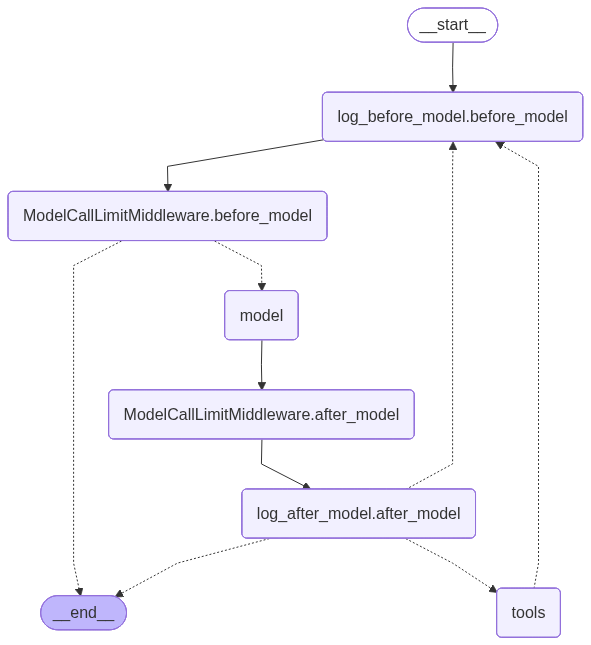

In [31]:
# Display the agent graph
try:
    from IPython.display import display, Image
    display(Image(wellness_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nAgent structure:")
    print(wellness_agent.get_graph().draw_ascii())

---
## ❓ Question #3:

How does **Agentic RAG** differ from traditional RAG? What are the advantages and potential disadvantages of letting the agent decide when to retrieve information?

##### ✅ Answer:
Traditional RAG is deterministic model where we always retrieve chunks from the vector store, provide the results back to LLM, which will return the result. For agentic RAG, RAG or the retriver becomes a tool that agent can call dynamically through reasoning, where agent decides whether or not to call the tool to retrieve information.

Advantages:
- When done properly, agentic RAG can be more efficient to complete a user request. For example agent can decide if retrival tool call is needed dependending on the context. 
- Since RAG is a tool, agent can chain multiple tools together to complete more advanced tasks in a more flexible way, where agent can break down complext task into multiple steps with tool calls.

Disadvantages:
- Agent can potentially call the tool many times or even stuck in an infinite loop.
- Agent may not retrieve the most relevant information.
- Agent may not call the right tool due to ambiguous docstring for example.
- Since agent decides when and what tool to use, the tool/function calling might fail to call retrival.

## ❓ Question #4:

Looking at the middleware examples (`log_before_model`, `log_after_model`, and `ModelCallLimitMiddleware`), describe a real-world scenario where middleware would be essential for a production agent. What specific middleware hooks would you use and why?

##### ✅ Answer:

For a production agent, middleware will be useful in many scenarios, for example:
- Add logging and telemetry information before and after each model call
- Detect and handle Personally Identifiable Information (PII), for example examine if PII is fed to the model before each model call; and examine if PII is added to the model response via after model call
- Pause system execution before a tool call when human-in-the-loop is needed for approval of tool uses.

In a speicifc usecase, let's say we build a healthcare agent that answer patient question, it should never leak sensitive information. Middleware hooks can be used in:
- `before_model`: scan for PII (e.g., SSN) from user's input, and if PII is detected, either block the request to lLM, or ask for human approval to proceed with caution;
- `after_model`: scan the model's reponse to ensure it doesn't include PII. 

---
## 🏗️ Activity #2: Enhance the Agentic RAG System

Now it's your turn! Enhance the wellness agent by implementing ONE of the following:

### Option A: Add a New Tool
Create a new tool that the agent can use. Ideas:
- A tool that calculates BMI given height and weight
- A tool that estimates daily calorie needs
- A tool that creates a simple workout plan

### Option B: Create Custom Middleware
Build middleware that adds new functionality:
- Middleware that tracks which tools are used most frequently
- Middleware that adds a friendly greeting to responses
- Middleware that enforces a response length limit

### Option C: Improve the RAG Tool
Enhance the retrieval tool:
- Add metadata filtering
- Implement reranking of results
- Add source citations with relevance scores

### Option A: Add new tools to the agent



In [32]:
from langchain_core.tools import tool

@tool
def calculate_bmi(height_cm: float, weight_kg: float) -> str:
    """Calculate the Body Mass Index (BMI) based on height and weight.

    Height needs to be in centimeters and weight needs to be in kilograms, 
    convert height to centimeters and weight to kilograms before calculation.
    
    Use this tool when the user asks questions about body mass index or BMI
    
    Args:
        height_cm: The height in centimeters
        weight_kg: The weight in kilograms
    """
    bmi = weight_kg / (height_cm / 100) ** 2
    return f"Body Mass Index (BMI) is {bmi:.2f}"

print(f"Tool created: {calculate_bmi.name}")
print(f"Description: {calculate_bmi.description[:100]}...")

Tool created: calculate_bmi
Description: Calculate the Body Mass Index (BMI) based on height and weight.

    Height needs to be in centimete...


In [33]:
@tool
def create_workout_plan(
    fitness_goal: str,
    measurements: str = None,
) -> str:
    """Create a personalized workout plan based on fitness goals, level, and other preferences.

    Args:
        fitness_goal: A description of the user's fitness goals, preferences, and limitations
        measurements: Optional, the user's body measurements (e.g., height, weight, BMI)
    """

    from langchain_openai import ChatOpenAI

    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)

    user_prompt = f"Create a workout plan for: {fitness_goal}"
    if measurements:
        user_prompt += f"\n\nUser measurements: {measurements}"
    
    messages = [
        (
            "system",
            """You are a certified personal trainer. Create safe, effective workout plans.
Keep plans simple, actionable, and formatted clearly by day."""
        ),
        ("human", user_prompt),
    ]

    response = llm.invoke(messages)


    return response.content

print(f"Tool created: {create_workout_plan.name}")
print(f"Description: {create_workout_plan.description[:100]}...")

Tool created: create_workout_plan
Description: Create a personalized workout plan based on fitness goals, level, and other preferences.

    Args:
...


In [34]:
# Test your enhanced agent here

from langchain.agents import create_agent

# Reset the call counter
model_call_count = 0

# Define our tools - include the RAG tool and the calculator from earlier
rag_tools = [
    search_wellness_knowledge,
    calculate,
    get_current_time,
    calculate_bmi,
    create_workout_plan
]

# Create the agentic RAG system with middleware
wellness_agent = create_agent(
    model="gpt-5",
    tools=rag_tools,
    system_prompt="""You are a helpful wellness assistant with access to a comprehensive health and wellness knowledge base.

Your role is to:
1. Answer questions about health, fitness, nutrition, sleep, and mental wellness
2. Always search the knowledge base when the user asks wellness-related questions
3. Provide accurate, helpful information based on the retrieved context
4. Be supportive and encouraging in your responses
5. If you cannot find relevant information, say so honestly

Remember: Always cite information from the knowledge base when applicable.""",
    middleware=[
        log_before_model,
        log_after_model,
        call_limiter
    ]
)

print("Wellness Agent created with middleware!")

Wellness Agent created with middleware!


In [35]:
# Test the wellness agent with BMI calculation
print("Testing Wellness Agent with BMI calculation")
print("=" * 50)

response = wellness_agent.invoke(
    {"messages": [{"role": "user", "content": "What is my BMI if I am 5 feet 10 inches and 180 pounds?"}]}
)

print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(response["messages"][-1].content)

Testing Wellness Agent with BMI calculation
[LOG] Model call #1 - Messages in state: 1
[LOG] After model - Tool calls requested: [{'name': 'calculate_bmi', 'args': {'height_cm': 177.8, 'weight_kg': 81.65}, 'id': 'call_hmfb3VFpy1AW8ptjJ29fUL7S', 'type': 'tool_call'}, {'name': 'search_wellness_knowledge', 'args': {'query': 'adult BMI categories ranges underweight normal overweight obesity interpretation'}, 'id': 'call_vhNxkRPPMcCktxInc1tRXL4A', 'type': 'tool_call'}]
[LOG] Model call #2 - Messages in state: 4
[LOG] After model - Tool calls requested: [{'name': 'search_wellness_knowledge', 'args': {'query': 'adult BMI categories underweight <18.5 normal 18.5-24.9 overweight 25-29.9 obese ≥30 interpretation limitations'}, 'id': 'call_SAsPzeCAK2EpI4qpA3oWRss2', 'type': 'tool_call'}]
[LOG] Model call #3 - Messages in state: 6
[LOG] After model - Tool calls requested: [{'name': 'search_wellness_knowledge', 'args': {'query': 'BMI categories adults: underweight <18.5, normal 18.5-24.9, overweigh

In [36]:
# Test the wellness agent with BMI calculation and workout plan tool
print("Testing Wellness Agent with workout plan tool")
print("=" * 50)

response = wellness_agent.invoke(
    {"messages": [{"role": "user", "content": "What is my BMI if I am 5 feet 10 inches and 180 pounds? Also create a workout plan for me."}]}
)

print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(response["messages"][-1].content)

Testing Wellness Agent with workout plan tool
[LOG] Model call #6 - Messages in state: 1
[LOG] After model - Tool calls requested: [{'name': 'search_wellness_knowledge', 'args': {'query': 'BMI categories adult WHO or CDC ranges underweight normal overweight obesity'}, 'id': 'call_8zAeJN2vFRiFbtJ9kCkzrHRD', 'type': 'tool_call'}, {'name': 'search_wellness_knowledge', 'args': {'query': 'exercise guidelines adults 150 minutes moderate or 75 minutes vigorous plus 2 days strength training'}, 'id': 'call_YumYnfk7hKdr7uezfXD9PbTj', 'type': 'tool_call'}, {'name': 'calculate_bmi', 'args': {'height_cm': 177.8, 'weight_kg': 81.65}, 'id': 'call_vwsGgxgPeewKCs5LeQnTNGuI', 'type': 'tool_call'}]
[LOG] Model call #7 - Messages in state: 5
[LOG] After model - Tool calls requested: [{'name': 'search_wellness_knowledge', 'args': {'query': 'BMI categories underweight normal overweight obesity ranges adults'}, 'id': 'call_lFSR8bDU3tFeOnHXVirxIosw', 'type': 'tool_call'}]
[LOG] Model call #8 - Messages in sta

### Observation for Option A: Add new tools to the agent
We have added two new tools to the agent
- calculate_bmi: a deterministic calcuation for BMI based on height and weight
- create_workout_plan: a tool that calls a light-weigth LLM model to create a quick resposne for workout plan

Observations: 
- The model performs well on calling the right tool to complete user query
- The model/agent is able to convert into metrics units when given ft/inch and lb for `calculate_bmi` call. 



### Option B: Create custom middleware



In [37]:
from langchain.agents.middleware import before_model, after_model
from collections import defaultdict

# Track how many model calls we've made
tool_call_count = defaultdict(int)

@after_model
def log_tool_call_count(state, runtime):
    """Log the model call count for each tool."""
    last_message = state.get("messages", [])[-1]
    if last_message and hasattr(last_message, "tool_calls") and last_message.tool_calls:
        for tool_call in last_message.tool_calls:
            tool_call_count[tool_call["name"]] += 1
            print(f"Tool {tool_call['name']} called {tool_call_count[tool_call['name']]} times")

    return None

## Create max response length middleware
MAX_RESPONSE_LENGTH = 1000

@after_model
def enforce_max_response_length(state, runtime):
    """Enforce the maximum response length and truncate the response if necessary."""
    last_message = state.get("messages", [])[-1] if state.get("messages") else None
    if last_message and hasattr(last_message, "content") and last_message.content:
        has_tool_calls = hasattr(last_message, 'tool_calls') and last_message.tool_calls

        # Only truncate the final response, not tool call responses
        if not has_tool_calls and len(last_message.content) > MAX_RESPONSE_LENGTH:
            last_message.content = last_message.content[:MAX_RESPONSE_LENGTH] + "... [truncated]"
            print(f"Response truncated to {MAX_RESPONSE_LENGTH} characters")
    return None

In [38]:
# Test your enhanced agent here

from langchain.agents import create_agent

# Reset the call counter
model_call_count = 0

# Define our tools - include the RAG tool and the calculator from earlier
rag_tools = [
    search_wellness_knowledge,
    calculate,
    get_current_time,
    calculate_bmi,
    create_workout_plan
]

# Create the agentic RAG system with middleware
wellness_agent = create_agent(
    model="gpt-5",
    tools=rag_tools,
    system_prompt="""You are a helpful wellness assistant with access to a comprehensive health and wellness knowledge base.

Your role is to:
1. Answer questions about health, fitness, nutrition, sleep, and mental wellness
2. Always search the knowledge base when the user asks wellness-related questions
3. Provide accurate, helpful information based on the retrieved context
4. Be supportive and encouraging in your responses
5. If you cannot find relevant information, say so honestly

Remember: Always cite information from the knowledge base when applicable.""",
    middleware=[
        log_before_model,
        log_after_model,
        call_limiter,
        log_tool_call_count,
        enforce_max_response_length
    ]
)

print("Wellness Agent created with middleware!")

Wellness Agent created with middleware!


In [39]:
# Test the middleware hooks 

print("Testing Wellness Agent with workout plan tool")
print("=" * 50)

response = wellness_agent.invoke(
    {"messages": [{"role": "user", "content": "Create a workout plan for me to lose 10 pounds in 2 weeks if I'm 5'10\" and 200 lbs"}]}
)

print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(response["messages"][-1].content)

Testing Wellness Agent with workout plan tool
[LOG] Model call #1 - Messages in state: 1
Tool search_wellness_knowledge called 1 times
Tool search_wellness_knowledge called 2 times
Tool search_wellness_knowledge called 3 times
Tool search_wellness_knowledge called 4 times
Tool search_wellness_knowledge called 5 times
Tool search_wellness_knowledge called 6 times
Tool calculate_bmi called 1 times
[LOG] After model - Tool calls requested: [{'name': 'search_wellness_knowledge', 'args': {'query': 'Safe rate of weight loss per week guideline (CDC/ACSM) 1-2 pounds per week and risks of rapid weight loss'}, 'id': 'call_tvEMoMbNakU13bMdrZKSxez8', 'type': 'tool_call'}, {'name': 'search_wellness_knowledge', 'args': {'query': 'ACSM or WHO physical activity guidelines for weight loss: recommended minutes per week of moderate/vigorous aerobic activity and resistance training frequency'}, 'id': 'call_G3tvut0dVhPxUXMXsvNdXvJ4', 'type': 'tool_call'}, {'name': 'search_wellness_knowledge', 'args': {'que

In [40]:
## Check the tool call count
for tool_name, count in tool_call_count.items():
    print(f"Tool {tool_name} called {count} times")


Tool search_wellness_knowledge called 6 times
Tool calculate_bmi called 1 times


### Observation for Option B: Create custom middleware
We can see the custom middleware is working as expected where the tool_call_count hook has recorded the number of times each time called.

In additoin, from the final response, we can see the response is trunked when it exceeds the max response length with the `... [truncated]` part at the end of the response. 

### Option C: Enhance RAG tool

#### Enhance RAG tool with metadata

In [41]:
## Add metadata to the RAG tool
## Add the following metadata to the RAG tool
# - topics: the topics discussed in the chunk
# - chunk_id: the id of the chunk
# - source: the source document of the chunk

def add_metadata(chunks: list[str], source: str) -> list['Document']:
    """Add metadata to the chunks."""

    documents = []

    topics_keywords = {
        "exercise": ["exercise", "workout", "stretch", "muscle", "fitness", "training"],
        "sleep": ["sleep", "insomnia", "bedtime", "rest", "tired", "wake"],
        "nutrition": ["nutrition", "diet", "food", "meal", "eat", "vitamin", "protein"],
        "stress": ["stress", "anxiety", "meditation", "mindful", "relax", "calm"],
    }

    for idx, chunk in enumerate(chunks, 1):
        # Extract topics from the chunk content
        topics = []
        for topic, keywords in topics_keywords.items():
            if any(keyword in chunk.lower() for keyword in keywords):
                topics.append(topic)

        if not topics:
            topics = ["general"]

        documents.append(Document(
            page_content=chunk,
            metadata={
                "topics": topics,
                "chunk_id": idx,
                "source": source
            }
        ))   

    return documents




In [42]:
# Create the vector store and add documents
from langchain_core.documents import Document

# Add metadata to each chunk and convert to LangChain Document objects
langchain_docs_metadata = add_metadata(chunks, "HealthWellnessGuide.txt")

for doc in langchain_docs_metadata:
    print(doc.metadata)

{'topics': ['exercise'], 'chunk_id': 1, 'source': 'HealthWellnessGuide.txt'}
{'topics': ['exercise'], 'chunk_id': 2, 'source': 'HealthWellnessGuide.txt'}
{'topics': ['exercise'], 'chunk_id': 3, 'source': 'HealthWellnessGuide.txt'}
{'topics': ['exercise'], 'chunk_id': 4, 'source': 'HealthWellnessGuide.txt'}
{'topics': ['exercise', 'nutrition'], 'chunk_id': 5, 'source': 'HealthWellnessGuide.txt'}
{'topics': ['exercise', 'nutrition'], 'chunk_id': 6, 'source': 'HealthWellnessGuide.txt'}
{'topics': ['exercise', 'sleep', 'nutrition'], 'chunk_id': 7, 'source': 'HealthWellnessGuide.txt'}
{'topics': ['exercise', 'sleep', 'nutrition', 'stress'], 'chunk_id': 8, 'source': 'HealthWellnessGuide.txt'}
{'topics': ['exercise', 'nutrition'], 'chunk_id': 9, 'source': 'HealthWellnessGuide.txt'}
{'topics': ['nutrition', 'stress'], 'chunk_id': 10, 'source': 'HealthWellnessGuide.txt'}
{'topics': ['nutrition', 'stress'], 'chunk_id': 11, 'source': 'HealthWellnessGuide.txt'}
{'topics': ['general'], 'chunk_id': 

In [43]:
# Create Qdrant client (in-memory for development)
qdrant_client = QdrantClient(":memory:")

# Create a collection for our wellness documents
metadata_collection_name = "wellness_knowledge_base_metadata"

qdrant_client.create_collection(
    collection_name=metadata_collection_name,
    vectors_config=VectorParams(
        size=embedding_dim,
        distance=Distance.COSINE
    )
)

True

In [44]:
# Create vector store
vector_store_metadata = QdrantVectorStore(
    client=qdrant_client,
    collection_name=metadata_collection_name,
    embedding=embedding_model
)

# Add documents to the vector store
vector_store_metadata.add_documents(langchain_docs_metadata)

print(f"Added {len(langchain_docs_metadata)} documents to vector store with metadata")

Added 41 documents to vector store with metadata


In [45]:
from qdrant_client.http import models

@tool
def search_wellness_knowledge_metadata(query: str, topic: str = None) -> str:
    """Search the wellness knowledge base for health information.
    
    Args:
        query: The search query
        topic: Optional topic filter, or None for all
    """

    filter_condition = None
    
    if topic:
        filter_condition = models.Filter(
            must=[
                models.FieldCondition(
                    key="metadata.topics",
                    match=models.MatchAny(any=[topic])
                )
            ]
        )
    
    results = vector_store_metadata.similarity_search(query, k=3, filter=filter_condition)
    
    if not results:
        return "No relevant information found."
    
    formatted = []
    for doc in results:
        chunk_id = doc.metadata.get("chunk_id", "?")
        topics = doc.metadata.get("topics", [])
        formatted.append(f"[Chunk #{chunk_id}] (Topics: {', '.join(topics)})\n{doc.page_content[:100]}...")
    
    return "\n\n".join(formatted)


In [46]:
# Test Without filter
print("=== No filter ===")
print(search_wellness_knowledge_metadata.invoke({"query": "how to eat healthy"}))

=== No filter ===
[Chunk #9] (Topics: exercise, nutrition)
ls of Healthy Eating

A balanced diet provides your body with the nutrients it needs to function pro...

[Chunk #11] (Topics: nutrition, stress)
l planning saves time, reduces stress, and helps maintain a healthy diet.

Weekly Meal Planning Step...

[Chunk #10] (Topics: nutrition, stress)
for hormone production and nutrient absorption. Focus on healthy fats from olive oil, avocados, nuts...


In [47]:
# Test with topic filter
print("\n=== Filter: sleep ===")
print(search_wellness_knowledge_metadata.invoke({"query": "how to eat healthy", "topic": "sleep"}))

print("\n=== Filter: stress ===")
print(search_wellness_knowledge_metadata.invoke({"query": "how to eat healthy", "topic": "stress"}))


=== Filter: sleep ===
[Chunk #40] (Topics: sleep, nutrition, stress)
de for sunlight
4. Power pose for 2 minutes
5. Healthy snack (nuts, fruit)
6. Brief walk around the ...

[Chunk #14] (Topics: sleep, nutrition)
ods like cucumbers, watermelon, and oranges
- Drink a glass of water before each meal

PART 3: SLEEP...

[Chunk #41] (Topics: sleep, stress)
cklist:
- 8 glasses of water
- 5+ servings of fruits/vegetables
- 30 minutes of movement
- 7-9 hours...

=== Filter: stress ===
[Chunk #11] (Topics: nutrition, stress)
l planning saves time, reduces stress, and helps maintain a healthy diet.

Weekly Meal Planning Step...

[Chunk #10] (Topics: nutrition, stress)
for hormone production and nutrient absorption. Focus on healthy fats from olive oil, avocados, nuts...

[Chunk #33] (Topics: exercise, nutrition, stress)
plenty of fruits and vegetables
- Exercise regularly but moderately
- Manage stress effectively
- St...


In [48]:
## Test topic filter with our RAG tool

from langchain.agents import create_agent

# Reset call counter
model_call_count = 0

# Use the new metadata-enabled tool
rag_tools_v2 = [
    search_wellness_knowledge_metadata,  # The new tool with topic filtering
    calculate,
    get_current_time
]

# Create agent
wellness_agent_metadata = create_agent(
    model="gpt-5",
    tools=rag_tools_v2,
    system_prompt="""You are a helpful wellness assistant with access to a comprehensive health and wellness knowledge base.

Your role is to:
1. Answer questions about health, fitness, nutrition, sleep, and mental wellness
2. Search the knowledge base when the user asks wellness-related questions
3. Use the topic filter when the user's question is clearly about a specific topic (exercise, sleep, nutrition, stress)
4. Provide accurate, helpful information based on the retrieved context
5. Be supportive and encouraging in your responses

Available topic filters: "exercise", "sleep", "nutrition", "stress" (or None for all topics)""",
    middleware=[
        log_before_model,
        log_after_model,
        call_limiter
    ]
)

print("Wellness Agent created with metadata filtering!")


Wellness Agent created with metadata filtering!


In [49]:
print("Test: Sleep-specific question")
print("=" * 50)

response = wellness_agent_metadata.invoke(
    {"messages": [{"role": "user", "content": "What are some tips for better sleep?"}]}
)
print("\nFINAL RESPONSE:")
print(response["messages"][-1].content)

Test: Sleep-specific question
[LOG] Model call #1 - Messages in state: 1
[LOG] After model - Tool calls requested: [{'name': 'search_wellness_knowledge_metadata', 'args': {'query': 'tips for better sleep, sleep hygiene, circadian rhythm, bedtime routine, caffeine timing, alcohol impact on sleep, blue light, exercise timing, bedroom temperature, insomnia strategies CBT-I, naps, morning light exposure', 'topic': 'sleep'}, 'id': 'call_9RJBboEYHRH0QQz3eSydNLmi', 'type': 'tool_call'}]
[LOG] Model call #2 - Messages in state: 3
[LOG] After model - Tool calls requested: []

FINAL RESPONSE:
Here are evidence-based tips that help most people sleep better:

- Keep a consistent schedule: Wake up and go to bed at the same time every day (yes, weekends). A fixed wake time is the best anchor.
- Get morning light: 10–30 minutes of outdoor light within an hour of waking helps set your circadian rhythm. Dim lights in the evening.
- Create a wind-down routine (30–60 minutes): Try reading, gentle stretch

### Observation for Option C: Enhance RAG tool with metadata
We can see the metadata-enabled RAG tool is working as expected where the agent is able to use the topic filter to retrieve the relevant information from the knowledge base. 






### Option C-2: add re-ranking for the RAG tool

In this seciton, we'll use CrossEncoder to re-rank the retrieved chunks

In [52]:
from sentence_transformers import CrossEncoder

# Load the pre-trained CrossEncoder model
reranker = CrossEncoder('cross-encoder/ms-marco-MiniLM-L6-v2')

# Re-define search wellkness knowledge tool with re-ranking
from qdrant_client.http import models

@tool
def search_wellness_knowledge_rerank(query: str, topic: str = None) -> str:
    """Search the wellness knowledge base for health information.
    
    Args:
        query: The search query
        topic: Optional topic filter, or None for all
    """

    filter_condition = None
    
    if topic:
        filter_condition = models.Filter(
            must=[
                models.FieldCondition(
                    key="metadata.topics",
                    match=models.MatchAny(any=[topic])
                )
            ]
        )
    
    ## Use a higher k value to retrieve more chunks for re-ranking
    candidate_chunks = vector_store_metadata.similarity_search(query, k=6, filter=filter_condition)
    
    if not candidate_chunks:
        return "No relevant information found."

    # Use CrossEncoder to re-rank the candidate chunks
    query_chunk_pairs = [(query, chunk.page_content) for chunk in candidate_chunks]
    scores = reranker.predict(query_chunk_pairs)

    # Sort the candidate chunks by the scores
    ranked_chunks = sorted(zip(candidate_chunks, scores), key=lambda x: x[1], reverse=True)

    # Get the re-ranked chunks and only return the top 3 chunks
    formatted = []
    for doc, score in ranked_chunks[:3]:
        chunk_id = doc.metadata.get("chunk_id", "?")
        topics = doc.metadata.get("topics", [])
        formatted.append(f"[Chunk #{chunk_id}] (Topics: {', '.join(topics)}) (Rerank Score: {score:.2f})\n{doc.page_content}")
    
    return "\n\n".join(formatted)


In [54]:
query = "how to reduce stress"

print("=== Without Reranking ===")
print(search_wellness_knowledge_metadata.invoke({"query": query}))

print("\n" + "=" * 60)

print("\n=== With Reranking ===")
print(search_wellness_knowledge_rerank.invoke({"query": query}))

=== Without Reranking ===
[Chunk #22] (Topics: exercise, sleep, stress)
 to calming music

Long-term stress management:
- Regular exercise
- Adequate sleep
- Social connect...

[Chunk #21] (Topics: exercise, sleep, nutrition, stress)
gement involves both immediate relief techniques and long-term lifestyle changes.

Immediate stress ...

[Chunk #23] (Topics: nutrition, stress)
Regular mindfulness practice has been shown to reduce stress, improve focus, and enhance emotional r...


=== With Reranking ===
[Chunk #23] (Topics: nutrition, stress) (Rerank Score: 5.05)
Regular mindfulness practice has been shown to reduce stress, improve focus, and enhance emotional regulation.

Basic mindfulness meditation:
1. Find a quiet, comfortable place to sit
2. Close your eyes and focus on your breath
3. Notice when your mind wanders (this is normal)
4. Gently return attention to your breath
5. Start with 5 minutes and gradually increase

Types of meditation:
- Focused attention: Concentrate on a sing

In [55]:
## Test re-ranking with our RAG tool

from langchain.agents import create_agent

# Reset call counter
model_call_count = 0

# Use the new metadata-enabled tool
rag_tools_v3 = [
    search_wellness_knowledge_rerank,  # The new tool with re-ranking
    calculate,
    get_current_time
]

# Create agent
wellness_agent_metadata = create_agent(
    model="gpt-5",
    tools=rag_tools_v3,
    system_prompt="""You are a helpful wellness assistant with access to a comprehensive health and wellness knowledge base.

Your role is to:
1. Answer questions about health, fitness, nutrition, sleep, and mental wellness
2. Search the knowledge base when the user asks wellness-related questions
3. Use the topic filter when the user's question is clearly about a specific topic (exercise, sleep, nutrition, stress)
4. Provide accurate, helpful information based on the retrieved context
5. Be supportive and encouraging in your responses

Available topic filters: "exercise", "sleep", "nutrition", "stress" (or None for all topics)""",
    middleware=[
        log_before_model,
        log_after_model,
        call_limiter
    ]
)

print("Wellness Agent created with re-ranking for retrival!")


Wellness Agent created with re-ranking for retrival!


In [56]:
print("Test: Sleep-specific question")
print("=" * 50)

response = wellness_agent_metadata.invoke(
    {"messages": [{"role": "user", "content": "What are some tips for better sleep?"}]}
)
print("\nFINAL RESPONSE:")
print(response["messages"][-1].content)

Test: Sleep-specific question
[LOG] Model call #1 - Messages in state: 1
[LOG] After model - Tool calls requested: [{'name': 'search_wellness_knowledge_rerank', 'args': {'query': 'proven tips for better sleep hygiene and insomnia management: circadian rhythm, light exposure, caffeine, alcohol, naps, exercise timing, bedroom environment (cool dark quiet), pre-sleep routine, relaxation techniques (breathing, progressive muscle relaxation), CBT-I basics (stimulus control, sleep restriction), when to seek medical help (sleep apnea signs), melatonin guidance, warm bath, blue light blocking, morning sunlight', 'topic': 'sleep'}, 'id': 'call_C7lqTUB22UsB0vvUKbBZoftn', 'type': 'tool_call'}]
[LOG] Model call #2 - Messages in state: 3
[LOG] After model - Tool calls requested: []

FINAL RESPONSE:
Here are evidence-based tips that reliably improve sleep:

- Keep a consistent schedule
  - Wake up and go to bed at the same times daily (weekends too). A consistent wake time is the strongest anchor.
 

### Observation for Option C-2: add re-ranking for the RAG tool
We can see the re-ranking is working as expected where the agent is able to re-rank the retrieved chunks, which can help to provide the most relevant information from the knowledge base through semantic meanings as opposed to simple similarity search




## Test human in the loop (HITL) middleware

This part will test human in the loop middleware with a simple example of pausing execution when calculate BMI tool is called.

In [114]:
from langchain.agents import create_agent
from langchain.agents.middleware import HumanInTheLoopMiddleware
from langgraph.checkpoint.memory import InMemorySaver

# Create agent with HITL middleware that will pause execution when calculate BMI tool is called
agent_with_hitl = create_agent(
    model="gpt-4o",
    tools=[calculate_bmi],
    system_prompt="""You are a helpful assistant that can calculate BMI.

CRITICAL RULES:
1. When you receive a BMI result from the calculate_bmi tool, USE THAT RESULT to respond.
2. NEVER call calculate_bmi more than once per user request.
3. If tool values differ from user's original request, they were corrected by human review.
4. After receiving a tool result, respond immediately. Do not call any more tools.
""",
    middleware=[
        HumanInTheLoopMiddleware(
            interrupt_on={
                "calculate_bmi": True,
            },
            description_prefix="Tool execution requires human approval"
        ),
        call_limiter
    ],
    checkpointer=InMemorySaver()
)



In [115]:
# Agent execution and approval handler function
from langgraph.types import Command

def run_agent_with_approval(agent, user_message, thread_id="test-hitl-thread", debug=False):
    config = {"configurable": {"thread_id": thread_id}} 

    if debug:
        print("=" * 60)
        print("STEP 1: Initial invoke")
        print("=" * 60)

    result = agent.invoke(
        {"messages": [{"role": "user", "content": user_message}]},
        config=config
    )
    
    if debug:
        print(f"Result keys: {result.keys()}")

    interrupt_count = 0
    
    # Loop until no more interrupts
    while "__interrupt__" in result:
        interrupt_count += 1
        interrupt = result["__interrupt__"][0]
        action = interrupt.value["action_requests"][0]

        if debug:
            print(f"\n{'=' * 60}")
            print(f"INTERRUPT #{interrupt_count}")
            print("=" * 60)
            print(f"Full interrupt value: {interrupt.value}")
        
        print("=" * 50)
        print(f"Tool: {action['name']}")
        print(f"Args: {action['args']}")
        print("=" * 50)

        decision = input("Decision (approve/reject/edit): ").strip().lower()

        if debug:
            print(f"\nResuming with decision: '{decision}'")

        if decision == "approve":
            result = agent.invoke(
                Command(resume={"decisions": [{
                    "type": "reject", 
                    "message": "User approved this action."
                }]}),                
                config=config
            )
        elif decision == "reject":
            result = agent.invoke(
                Command(resume={"decisions": [{
                    "type": "reject", 
                    "message": "User rejected this action. Do not retry."
                }]}),
                config=config
            )
        elif decision == "edit":
            print(f"Current args: {action['args']}")
            new_args = {}
            for key, value in action['args'].items():
                new_value = input(f"  {key} [{value}]: ").strip()
                new_args[key] = type(value)(new_value) if new_value else value
            
            if debug:
                print(f"Edited args: {new_args}")
            
            result = agent.invoke(
                Command(resume={"decisions": [{
                    "type": "edit",
                    "edited_action": {
                        "name": action['name'],
                        "args": new_args,
                        "message": f"Human reviewer intentionally changed values from {action['args']} to {new_args}. Use the new values."
                    }
                }]}),
                config=config
            )

        if debug:
            print(f"\n{'=' * 60}")
            print(f"RESULT AFTER RESUME #{interrupt_count}")
            print("=" * 60)
            print(f"Result keys: {result.keys()}")
            print(f"Messages count: {len(result.get('messages', []))}")
            
            for i, msg in enumerate(result.get("messages", [])):
                print(f"\n--- Message {i} ---")
                print(f"Type: {type(msg).__name__}")
                if hasattr(msg, 'content'):
                    content = msg.content[:200] if msg.content else '(empty)'
                    print(f"Content: {content}")
                if hasattr(msg, 'tool_calls') and msg.tool_calls:
                    print(f"Tool calls: {msg.tool_calls}")
    
    if debug:
        print(f"\n{'=' * 60}")
        print(f"COMPLETED - Total interrupts handled: {interrupt_count}")
        print("=" * 60)

    return result["messages"][-1].content


In [105]:
# Test it with approval
response = run_agent_with_approval(
    agent_with_hitl,
    "Calculate my BMI. I weigh 70kg and I'm 1.75m tall",
    thread_id=f"debug-{uuid4().hex[:8]}",  # Fresh thread each time
    debug=True
)

print(f"Response: \n{response}\n")


STEP 1: Initial invoke
Result keys: dict_keys(['messages', '__interrupt__'])

INTERRUPT #1
Full interrupt value: {'action_requests': [{'name': 'calculate_bmi', 'args': {'height_cm': 175, 'weight_kg': 70}, 'description': "Tool execution requires human approval\n\nTool: calculate_bmi\nArgs: {'height_cm': 175, 'weight_kg': 70}"}], 'review_configs': [{'action_name': 'calculate_bmi', 'allowed_decisions': ['approve', 'edit', 'reject']}]}
Tool: calculate_bmi
Args: {'height_cm': 175, 'weight_kg': 70}

Resuming with decision: 'approve'

RESULT AFTER RESUME #1
Result keys: dict_keys(['messages'])
Messages count: 4

--- Message 0 ---
Type: HumanMessage
Content: Calculate my BMI. I weigh 70kg and I'm 1.75m tall

--- Message 1 ---
Type: AIMessage
Content: (empty)
Tool calls: [{'name': 'calculate_bmi', 'args': {'height_cm': 175, 'weight_kg': 70}, 'id': 'call_U89cuXiOHGmozLuqzq8eyncI', 'type': 'tool_call'}]

--- Message 2 ---
Type: ToolMessage
Content: User approved this action.

--- Message 3 ---
Ty

In [106]:
# Test it with reject
response = run_agent_with_approval(
    agent_with_hitl,
    "Calculate my BMI. I weigh 70kg and I'm 1.75m tall",
    thread_id=f"debug-{uuid4().hex[:8]}",  # Fresh thread each time
    debug=True
)

print(f"Response: \n{response}\n")


STEP 1: Initial invoke
Result keys: dict_keys(['messages', '__interrupt__'])

INTERRUPT #1
Full interrupt value: {'action_requests': [{'name': 'calculate_bmi', 'args': {'height_cm': 175, 'weight_kg': 70}, 'description': "Tool execution requires human approval\n\nTool: calculate_bmi\nArgs: {'height_cm': 175, 'weight_kg': 70}"}], 'review_configs': [{'action_name': 'calculate_bmi', 'allowed_decisions': ['approve', 'edit', 'reject']}]}
Tool: calculate_bmi
Args: {'height_cm': 175, 'weight_kg': 70}

Resuming with decision: 'reject'

RESULT AFTER RESUME #1
Result keys: dict_keys(['messages'])
Messages count: 4

--- Message 0 ---
Type: HumanMessage
Content: Calculate my BMI. I weigh 70kg and I'm 1.75m tall

--- Message 1 ---
Type: AIMessage
Content: (empty)
Tool calls: [{'name': 'calculate_bmi', 'args': {'height_cm': 175, 'weight_kg': 70}, 'id': 'call_L23uz40Ycrg6gofjfNXr8d8k', 'type': 'tool_call'}]

--- Message 2 ---
Type: ToolMessage
Content: User rejected this action. Do not retry.

--- Mes

In [116]:
# Test it with edit
response = run_agent_with_approval(
    agent_with_hitl,
    "Calculate my BMI. I weigh 70kg and I'm 1.75m tall",
    thread_id=f"debug-{uuid4().hex[:8]}",  # Fresh thread each time
    debug=True
)

print(f"Response: \n{response}\n")


STEP 1: Initial invoke
Result keys: dict_keys(['messages', '__interrupt__'])

INTERRUPT #1
Full interrupt value: {'action_requests': [{'name': 'calculate_bmi', 'args': {'height_cm': 175, 'weight_kg': 70}, 'description': "Tool execution requires human approval\n\nTool: calculate_bmi\nArgs: {'height_cm': 175, 'weight_kg': 70}"}], 'review_configs': [{'action_name': 'calculate_bmi', 'allowed_decisions': ['approve', 'edit', 'reject']}]}
Tool: calculate_bmi
Args: {'height_cm': 175, 'weight_kg': 70}

Resuming with decision: 'edit'
Current args: {'height_cm': 175, 'weight_kg': 70}
Edited args: {'height_cm': 160, 'weight_kg': 80}

RESULT AFTER RESUME #1
Result keys: dict_keys(['messages'])
Messages count: 4

--- Message 0 ---
Type: HumanMessage
Content: Calculate my BMI. I weigh 70kg and I'm 1.75m tall

--- Message 1 ---
Type: AIMessage
Content: (empty)
Tool calls: [{'type': 'tool_call', 'name': 'calculate_bmi', 'args': {'height_cm': 160, 'weight_kg': 80}, 'id': 'call_dBsRRBOltf0E9C4On14KaGBX'}